# 05 - Seismic Gap Analysis

This notebook identifies seismic gaps along major fault lines in Turkey - segments with reduced seismic activity that may indicate elevated risk for future earthquakes.

## Theory
A seismic gap is a segment of an active fault that has not experienced significant earthquake activity for an extended period, despite adjacent segments being active. These gaps may represent areas where stress is accumulating.

## Contents
1. Setup and Data Loading
2. Fault Line Analysis
3. Earthquake Projection onto Faults
4. Gap Identification
5. Statistical Analysis of Gaps
6. Risk Assessment

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

from config import *
from visualization import setup_style, create_turkey_basemap
from geo_utils import (
    haversine_distance, 
    project_point_to_line,
    get_fault_segments,
    calculate_along_fault_distance
)

setup_style()

# Create output directory
OUTPUT_DIR = os.path.join(FIGURES_PATH, '05_seismic_gap')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')
fault_df = pd.read_csv(FAULT_DATA)

# Filter for significant earthquakes (M >= 4.0)
earthquakes = eq_df[eq_df['magnitude'] >= 4.0].copy()

print(f"Loaded {len(earthquakes):,} earthquakes (M >= 4.0)")
print(f"Loaded {len(fault_df)} fault segments")
fault_df.head()

Loaded 4,103 earthquakes (M >= 4.0)
Loaded 20 fault segments


,fault_id,fault_name,fault_name_en,fault_zone,segment,fault_type,fault_type_en,length_km,slip_rate_mm_yr,last_major_earthquake,...,lon_start,lat_end,lon_end,max_expected_magnitude,recurrence_interval_years,activity_class,seismic_gap,data_source,coordinate_system,last_update
0,NAF-001,Kuzey Anadolu Fayı - Marmara Segmenti,North Anatolian Fault - Marmara Segment,Kuzey Anadolu Fay Zonu,Marmara,Sağ yanal doğrultu atımlı,Right-lateral strike-slip,150,24,1999-08-17,...,29.86,40.45,27.50,7.4,250,A,True,MTA Türkiye Diri Fay Haritası 2013 + Literature,WGS84,2023-06-01
1,NAF-002,Kuzey Anadolu Fayı - Düzce Segmenti,North Anatolian Fault - Düzce Segment,Kuzey Anadolu Fay Zonu,Düzce,Sağ yanal doğrultu atımlı,Right-lateral strike-slip,40,22,1999-11-12,...,31.21,40.74,30.38,7.2,200,A,False,MTA Türkiye Diri Fay Haritası 2013 + Literature,WGS84,2023-06-01
2,NAF-003,Kuzey Anadolu Fayı - Erzincan Segmenti,North Anatolian Fault - Erzincan Segment,Kuzey Anadolu Fay Zonu,Erzincan,Sağ yanal doğrultu atımlı,Right-lateral strike-slip,120,20,1992-03-13,...,39.65,39.55,38.10,7.5,300,A,False,MTA Türkiye Diri Fay Haritası 2013 + Literature,WGS84,2023-06-01
3,NAF-004,Kuzey Anadolu Fayı - Niksar Segmenti,North Anatolian Fault - Niksar Segment,Kuzey Anadolu Fay Zonu,Niksar,Sağ yanal doğrultu atımlı,Right-lateral strike-slip,85,18,1942-12-20,...,37.20,40.55,35.80,7.3,280,A,True,MTA Türkiye Diri Fay Haritası 2013 + Literature,WGS84,2023-06-01
4,NAF-005,Kuzey Anadolu Fayı - Tosya Segmenti,North Anatolian Fault - Tosya Segment,Kuzey Anadolu Fay Zonu,Tosya,Sağ yanal doğrultu atımlı,Right-lateral strike-slip,95,20,1943-11-26,...,34.20,40.60,33.00,7.4,260,A,True,MTA Türkiye Diri Fay Haritası 2013 + Literature,WGS84,2023-06-01


## 2. Fault Line Analysis

In [2]:
# Calculate fault lengths
fault_df['length_km'] = fault_df.apply(
    lambda row: haversine_distance(row['lat_start'], row['lon_start'], row['lat_end'], row['lon_end']),
    axis=1
)

print("Fault Line Statistics:")
print(f"Total fault length: {fault_df['length_km'].sum():.1f} km")
print(f"Average fault length: {fault_df['length_km'].mean():.1f} km")
print(f"Longest fault: {fault_df.loc[fault_df['length_km'].idxmax(), 'fault_name']} ({fault_df['length_km'].max():.1f} km)")

fault_df[['fault_name', 'length_km', 'slip_rate_mm_yr', 'max_expected_magnitude']].sort_values('length_km', ascending=False)

Fault Line Statistics:
Total fault length: 2036.1 km
Average fault length: 101.8 km
Longest fault: Kuzey Anadolu Fayı - Marmara Segmenti (202.2 km)


,fault_name,length_km,slip_rate_mm_yr,max_expected_magnitude
0,Kuzey Anadolu Fayı - Marmara Segmenti,202.186419,24,7.4
16,Tuz Gölü Fay Zonu,172.335245,1,7.0
10,Büyük Menderes Grabeni Fayı,155.843036,4,7.0
15,Fethiye-Burdur Fay Zonu,142.302097,5,7.2
2,Kuzey Anadolu Fayı - Erzincan Segmenti,134.069982,20,7.5
3,Kuzey Anadolu Fayı - Niksar Segmenti,120.530760,18,7.3
6,Doğu Anadolu Fayı - Erkenek Segmenti,120.336448,10,7.6
9,Gediz Grabeni Fayı,117.716829,3,7.0
4,Kuzey Anadolu Fayı - Tosya Segmenti,110.366556,20,7.4
18,Ölü Deniz Fayı - Hatay Segmenti,99.577290,6,7.5


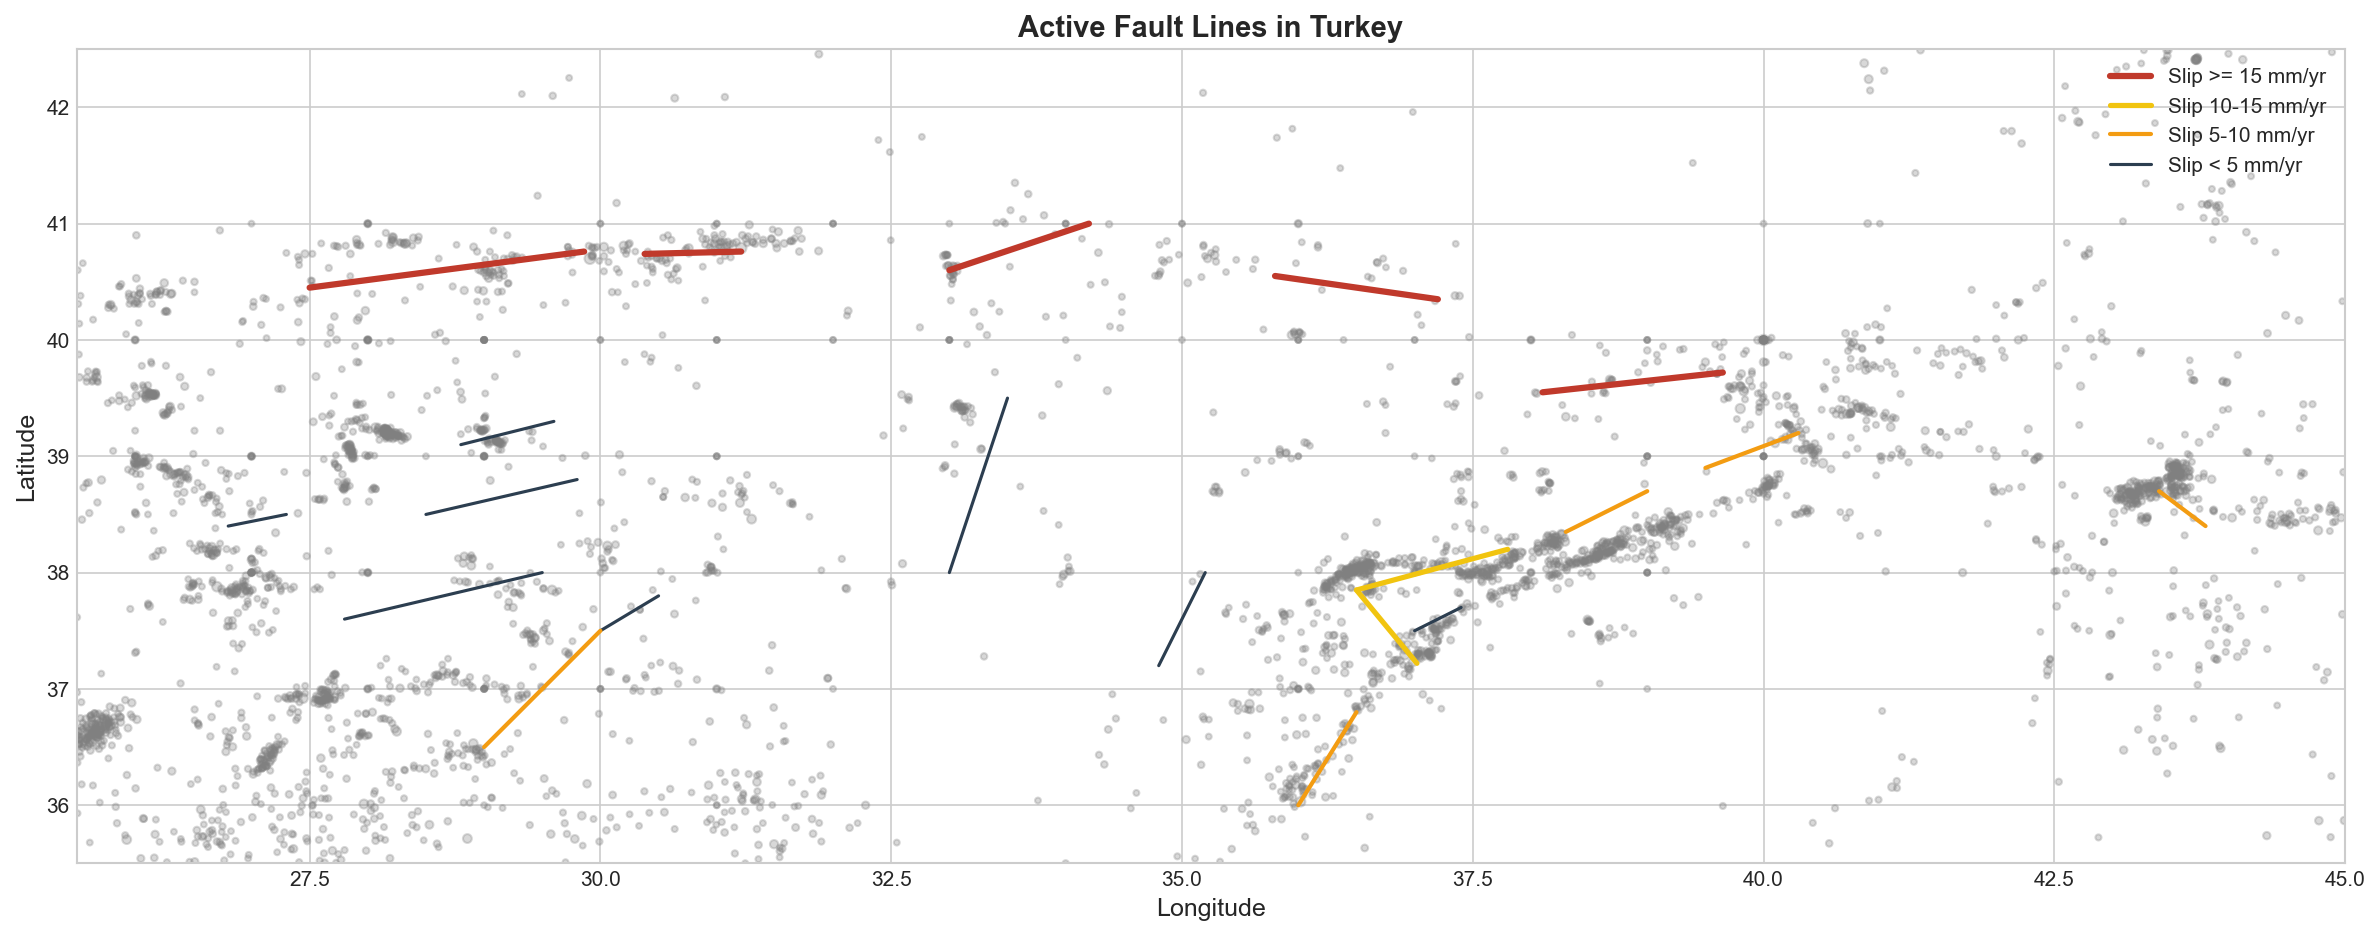

In [3]:
# Plot fault lines with slip rates
fig, ax = plt.subplots(figsize=(16, 10))
ax = create_turkey_basemap(ax, 'Active Fault Lines in Turkey')

# Plot faults colored by slip rate
for idx, fault in fault_df.iterrows():
    # Color by slip rate
    if fault['slip_rate_mm_yr'] >= 15:
        color = COLORS['danger']
        lw = 3
    elif fault['slip_rate_mm_yr'] >= 10:
        color = COLORS['warning']
        lw = 2.5
    elif fault['slip_rate_mm_yr'] >= 5:
        color = COLORS['accent']
        lw = 2
    else:
        color = COLORS['primary']
        lw = 1.5
    
    ax.plot([fault['lon_start'], fault['lon_end']], [fault['lat_start'], fault['lat_end']],
            color=color, linewidth=lw, zorder=5)

# Add earthquake points
ax.scatter(earthquakes['longitude'], earthquakes['latitude'], 
           s=earthquakes['magnitude']**2 / 2, alpha=0.3, c='gray')

# Legend
ax.plot([], [], color=COLORS['danger'], linewidth=3, label='Slip >= 15 mm/yr')
ax.plot([], [], color=COLORS['warning'], linewidth=2.5, label='Slip 10-15 mm/yr')
ax.plot([], [], color=COLORS['accent'], linewidth=2, label='Slip 5-10 mm/yr')
ax.plot([], [], color=COLORS['primary'], linewidth=1.5, label='Slip < 5 mm/yr')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'fault_lines_overview.png'), dpi=150, bbox_inches='tight')
plt.show()

## 3. Earthquake Projection onto Faults

In [4]:
def project_earthquakes_to_fault(eq_data, fault_row, max_distance_km=50):
    """
    Project earthquakes onto a fault line segment.
    
    Parameters
    ----------
    eq_data : DataFrame
        Earthquake data with latitude, longitude columns
    fault_row : Series
        Fault data with lat1, lon1, lat2, lon2
    max_distance_km : float
        Maximum perpendicular distance to consider
    
    Returns
    -------
    DataFrame
        Earthquakes with along-fault distance and perpendicular distance
    """
    projections = []
    
    for idx, eq in eq_data.iterrows():
        t, proj_lat, proj_lon, perp_dist = project_point_to_line(
            eq['latitude'], eq['longitude'],
            fault_row['lat_start'], fault_row['lon_start'],
            fault_row['lat_end'], fault_row['lon_end']
        )
        
        if perp_dist <= max_distance_km:
            along_dist = calculate_along_fault_distance(
                fault_row['lat_start'], fault_row['lon_start'],
                fault_row['lat_end'], fault_row['lon_end'], t
            )
            
            projections.append({
                'eventID': eq['eventID'],
                'date': eq['date'],
                'magnitude': eq['magnitude'],
                'depth': eq['depth'],
                'along_fault_km': along_dist,
                'perp_distance_km': perp_dist,
                't': t
            })
    
    return pd.DataFrame(projections)

print("Projection function defined.")

Projection function defined.


In [5]:
# Analyze major faults
major_faults = fault_df[fault_df['length_km'] >= 100].copy()
print(f"Analyzing {len(major_faults)} major fault segments (>= 100 km):")

fault_analysis_results = {}

for idx, fault in major_faults.iterrows():
    fault_name = fault['fault_name']
    print(f"\nProcessing: {fault_name} ({fault['length_km']:.1f} km)...")
    
    # Project earthquakes
    projections = project_earthquakes_to_fault(earthquakes, fault, max_distance_km=30)
    
    if len(projections) > 0:
        fault_analysis_results[fault_name] = {
            'fault_data': fault,
            'projections': projections,
            'n_earthquakes': len(projections)
        }
        print(f"  Found {len(projections)} earthquakes within 30 km")

Analyzing 9 major fault segments (>= 100 km):

Processing: Kuzey Anadolu Fayı - Marmara Segmenti (202.2 km)...
  Found 92 earthquakes within 30 km

Processing: Kuzey Anadolu Fayı - Erzincan Segmenti (134.1 km)...
  Found 56 earthquakes within 30 km

Processing: Kuzey Anadolu Fayı - Niksar Segmenti (120.5 km)...


  Found 15 earthquakes within 30 km

Processing: Kuzey Anadolu Fayı - Tosya Segmenti (110.4 km)...
  Found 38 earthquakes within 30 km

Processing: Doğu Anadolu Fayı - Erkenek Segmenti (120.3 km)...
  Found 342 earthquakes within 30 km

Processing: Gediz Grabeni Fayı (117.7 km)...


  Found 5 earthquakes within 30 km

Processing: Büyük Menderes Grabeni Fayı (155.8 km)...
  Found 34 earthquakes within 30 km

Processing: Fethiye-Burdur Fay Zonu (142.3 km)...
  Found 56 earthquakes within 30 km

Processing: Tuz Gölü Fay Zonu (172.3 km)...


  Found 20 earthquakes within 30 km


## 4. Gap Identification

In [6]:
def identify_seismic_gaps(projections, fault_length, segment_size_km=20, min_gap_threshold=0.3):
    """
    Identify seismic gaps along a fault.
    
    Parameters
    ----------
    projections : DataFrame
        Projected earthquakes with along_fault_km
    fault_length : float
        Total fault length in km
    segment_size_km : float
        Size of each segment to analyze
    min_gap_threshold : float
        Fraction of mean activity below which a segment is considered a gap
    
    Returns
    -------
    DataFrame
        Segment analysis with gap identification
    """
    n_segments = max(1, int(np.ceil(fault_length / segment_size_km)))
    segment_edges = np.linspace(0, fault_length, n_segments + 1)
    
    segments = []
    
    for i in range(n_segments):
        start = segment_edges[i]
        end = segment_edges[i + 1]
        center = (start + end) / 2
        
        # Count earthquakes in segment
        in_segment = (projections['along_fault_km'] >= start) & (projections['along_fault_km'] < end)
        count = in_segment.sum()
        
        # Get max magnitude in segment
        if count > 0:
            max_mag = projections.loc[in_segment, 'magnitude'].max()
            avg_mag = projections.loc[in_segment, 'magnitude'].mean()
        else:
            max_mag = 0
            avg_mag = 0
        
        segments.append({
            'segment_id': i,
            'start_km': start,
            'end_km': end,
            'center_km': center,
            'segment_length': end - start,
            'earthquake_count': count,
            'max_magnitude': max_mag,
            'avg_magnitude': avg_mag
        })
    
    segment_df = pd.DataFrame(segments)
    
    # Identify gaps (segments with activity below threshold * mean)
    mean_count = segment_df['earthquake_count'].mean()
    segment_df['is_gap'] = segment_df['earthquake_count'] < (mean_count * min_gap_threshold)
    segment_df['activity_ratio'] = segment_df['earthquake_count'] / max(mean_count, 1)
    
    return segment_df

print("Gap identification function defined.")

Gap identification function defined.


In [7]:
# Analyze gaps for each major fault
all_gap_results = {}

for fault_name, data in fault_analysis_results.items():
    fault = data['fault_data']
    projections = data['projections']
    
    if len(projections) >= 10:  # Need minimum earthquakes for analysis
        segment_analysis = identify_seismic_gaps(
            projections, 
            fault['length_km'],
            segment_size_km=20,
            min_gap_threshold=0.3
        )
        
        all_gap_results[fault_name] = {
            'fault_data': fault,
            'projections': projections,
            'segments': segment_analysis
        }

print(f"\nGap analysis completed for {len(all_gap_results)} faults.")


Gap analysis completed for 8 faults.


Most active fault: Doğu Anadolu Fayı - Erkenek Segmenti


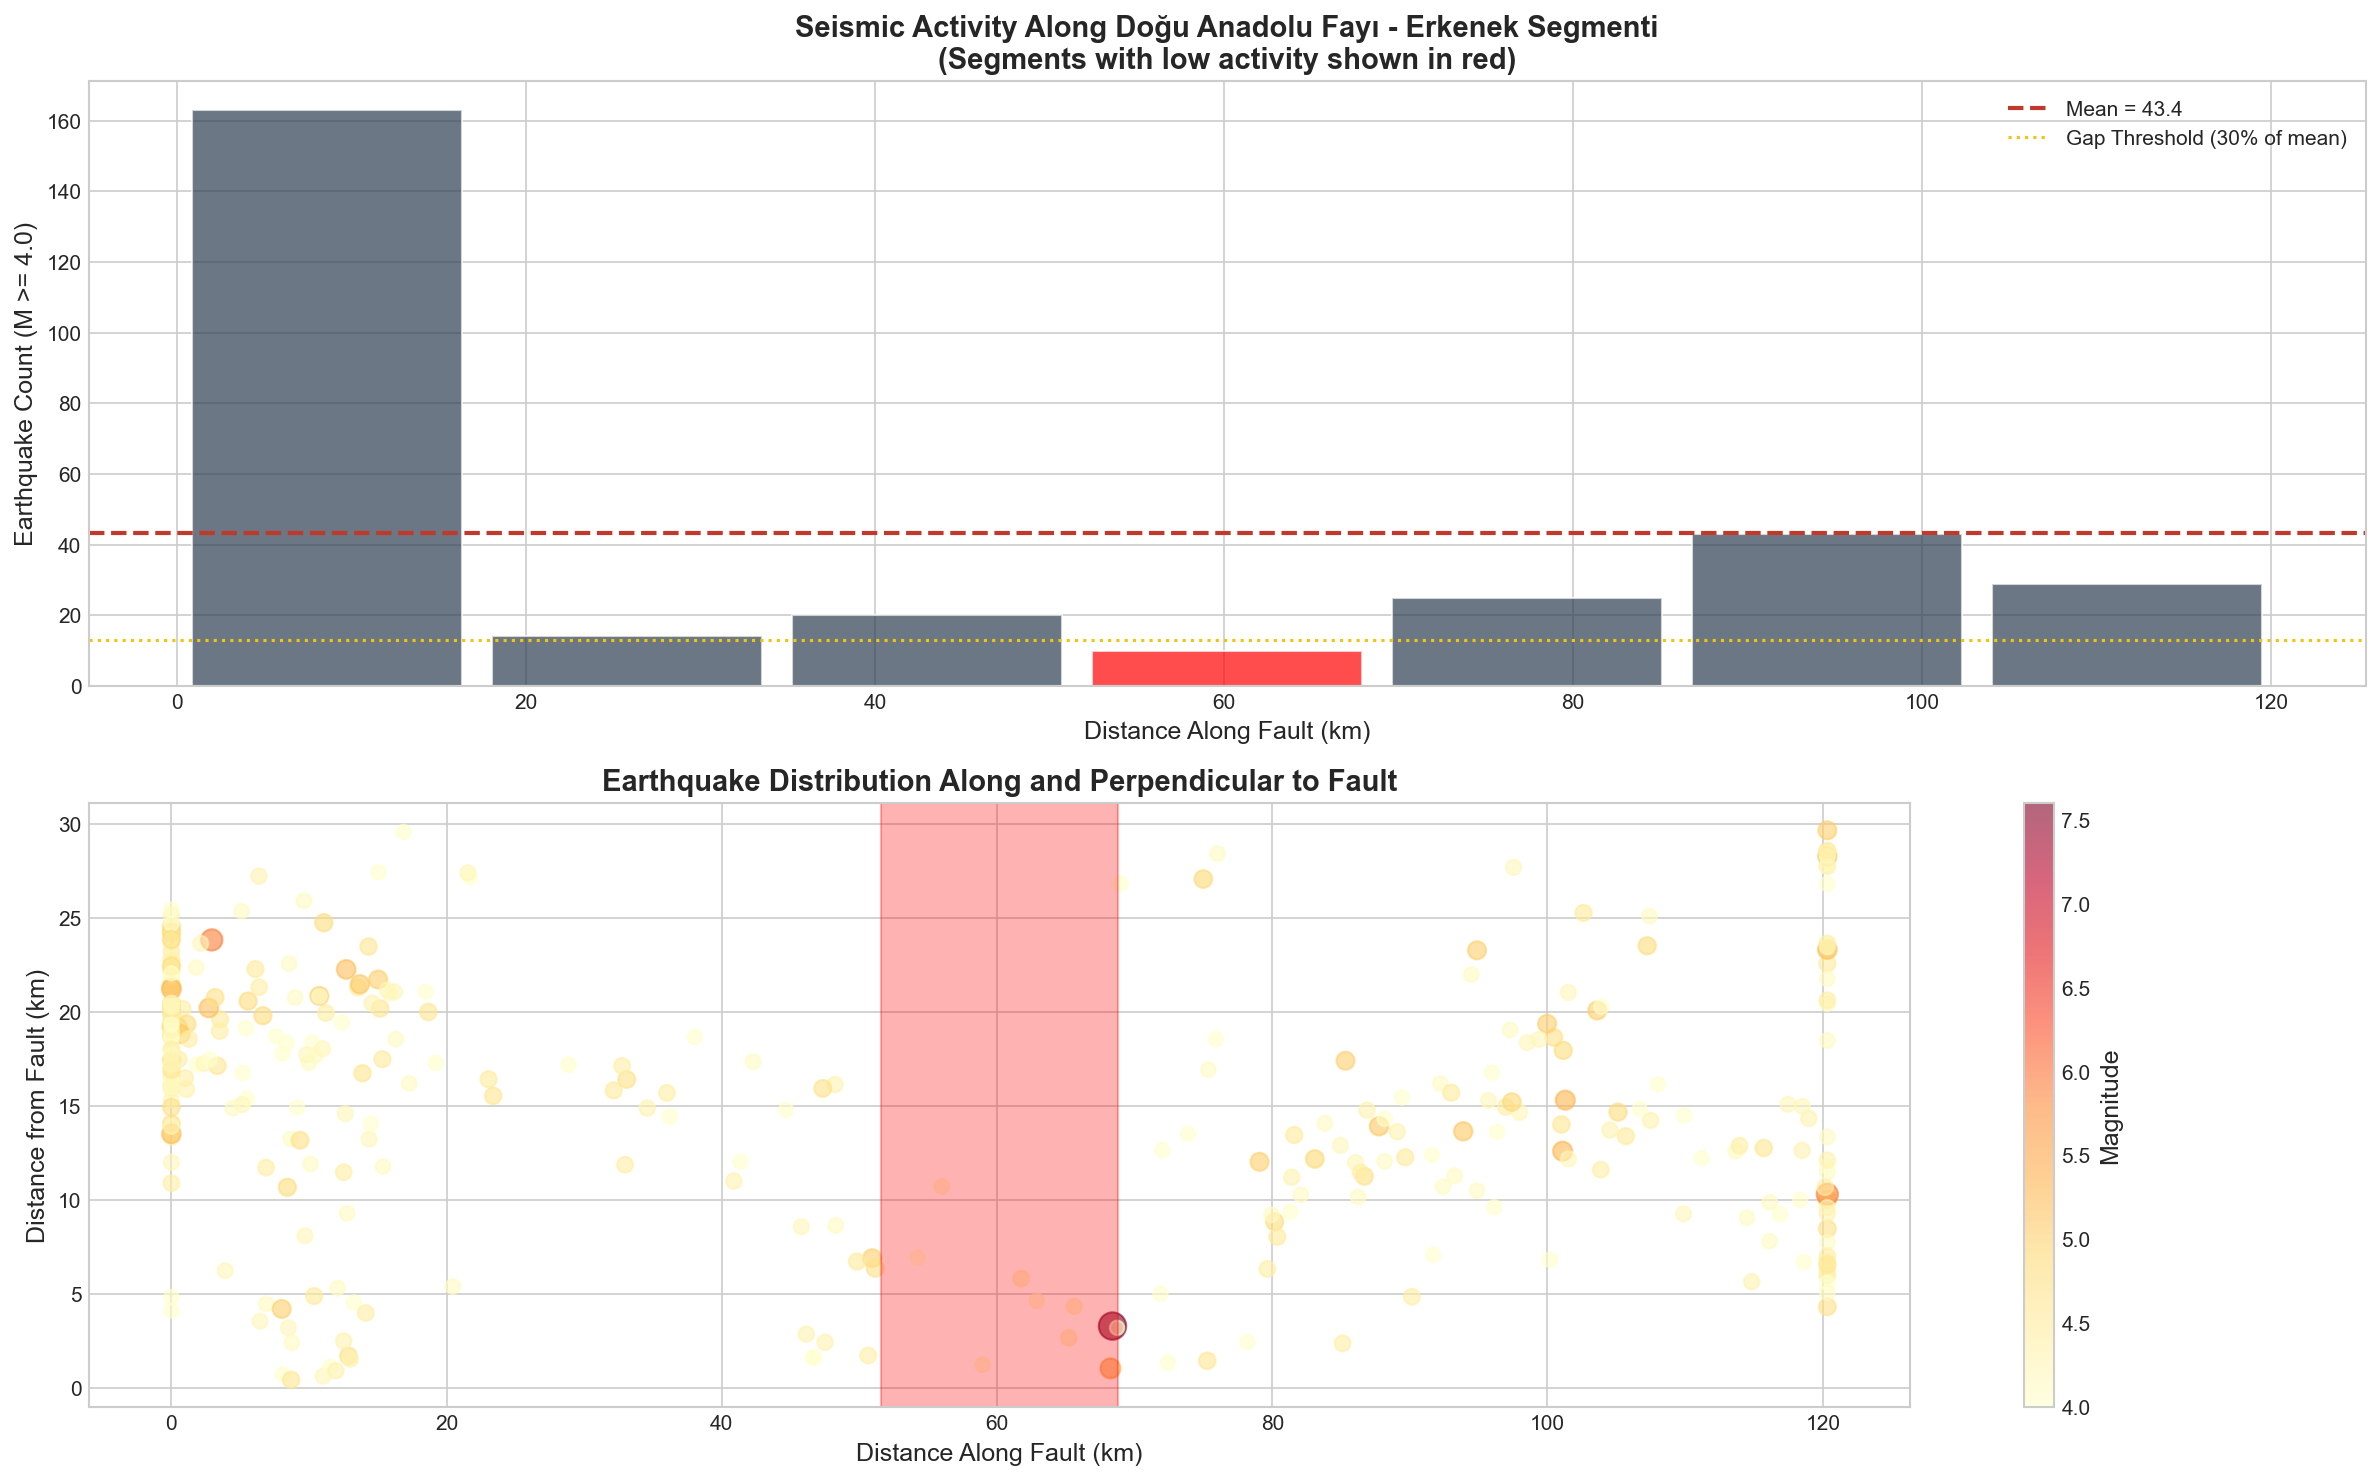

In [8]:
# Visualize gaps for the most seismically active fault
most_active_fault = max(all_gap_results.keys(), 
                        key=lambda x: len(all_gap_results[x]['projections']))

print(f"Most active fault: {most_active_fault}")

data = all_gap_results[most_active_fault]
segments = data['segments']
fault = data['fault_data']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Bar plot of earthquake counts per segment
ax1 = axes[0]
colors = ['red' if gap else COLORS['primary'] for gap in segments['is_gap']]
ax1.bar(segments['center_km'], segments['earthquake_count'], 
        width=segments['segment_length'].iloc[0] * 0.9, 
        color=colors, alpha=0.7, edgecolor='white')

# Mean line
mean_count = segments['earthquake_count'].mean()
ax1.axhline(mean_count, color=COLORS['danger'], linestyle='--', 
            linewidth=2, label=f'Mean = {mean_count:.1f}')
ax1.axhline(mean_count * 0.3, color=COLORS['warning'], linestyle=':', 
            linewidth=1.5, label='Gap Threshold (30% of mean)')

ax1.set_xlabel('Distance Along Fault (km)')
ax1.set_ylabel('Earthquake Count (M >= 4.0)')
ax1.set_title(f'Seismic Activity Along {most_active_fault}\n(Segments with low activity shown in red)', 
              fontweight='bold')
ax1.legend()

# Scatter plot of earthquakes along fault
ax2 = axes[1]
projections = data['projections']
scatter = ax2.scatter(projections['along_fault_km'], projections['perp_distance_km'],
                      c=projections['magnitude'], s=projections['magnitude']**2 * 3,
                      cmap='YlOrRd', alpha=0.6)
plt.colorbar(scatter, ax=ax2, label='Magnitude')

# Mark gaps
for _, seg in segments[segments['is_gap']].iterrows():
    ax2.axvspan(seg['start_km'], seg['end_km'], alpha=0.3, color='red', label='Gap')

ax2.set_xlabel('Distance Along Fault (km)')
ax2.set_ylabel('Distance from Fault (km)')
ax2.set_title('Earthquake Distribution Along and Perpendicular to Fault', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'gap_analysis_{most_active_fault.replace(" ", "_")}.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary of All Identified Gaps

In [9]:
# Compile all gaps
all_gaps = []

for fault_name, data in all_gap_results.items():
    fault = data['fault_data']
    segments = data['segments']
    gaps = segments[segments['is_gap']]
    
    for _, gap in gaps.iterrows():
        # Calculate approximate coordinates of gap center
        t = gap['center_km'] / fault['length_km']
        gap_lat = fault['lat_start'] + t * (fault['lat_end'] - fault['lat_start'])
        gap_lon = fault['lon_start'] + t * (fault['lon_end'] - fault['lon_start'])
        
        all_gaps.append({
            'fault_name': fault_name,
            'gap_start_km': gap['start_km'],
            'gap_end_km': gap['end_km'],
            'gap_length_km': gap['segment_length'],
            'earthquake_count': gap['earthquake_count'],
            'activity_ratio': gap['activity_ratio'],
            'gap_lat': gap_lat,
            'gap_lon': gap_lon,
            'slip_rate_mm_yr': fault['slip_rate_mm_yr'],
            'max_expected_mag': fault['max_expected_magnitude']
        })

gaps_df = pd.DataFrame(all_gaps)
print(f"Identified {len(gaps_df)} seismic gaps across all analyzed faults:")
gaps_df.head(10)

Identified 23 seismic gaps across all analyzed faults:


,fault_name,gap_start_km,gap_end_km,gap_length_km,earthquake_count,activity_ratio,gap_lat,gap_lon,slip_rate_mm_yr,max_expected_mag
0,Kuzey Anadolu Fayı - Marmara Segmenti,18.380584,36.761167,18.380584,0,0.000000,40.717727,29.538182,24,7.4
1,Kuzey Anadolu Fayı - Marmara Segmenti,91.902918,110.283501,18.380584,2,0.258824,40.605000,28.680000,24,7.4
2,Kuzey Anadolu Fayı - Marmara Segmenti,128.664085,147.044668,18.380584,2,0.258824,40.548636,28.250909,24,7.4
3,Kuzey Anadolu Fayı - Marmara Segmenti,147.044668,165.425252,18.380584,2,0.258824,40.520455,28.036364,24,7.4
4,Kuzey Anadolu Fayı - Erzincan Segmenti,19.152855,38.305709,19.152855,2,0.264151,39.683571,39.317857,20,7.5
5,Kuzey Anadolu Fayı - Erzincan Segmenti,57.458564,76.611418,19.152855,1,0.132075,39.635000,38.875000,20,7.5
6,Kuzey Anadolu Fayı - Erzincan Segmenti,114.917127,134.069982,19.152855,2,0.264151,39.562143,38.210714,20,7.5
7,Kuzey Anadolu Fayı - Niksar Segmenti,86.093400,103.312080,17.218680,0,0.000000,40.507143,36.100000,18,7.3
8,Kuzey Anadolu Fayı - Tosya Segmenti,36.788852,55.183278,18.394426,1,0.187500,40.833333,33.700000,20,7.4
9,Kuzey Anadolu Fayı - Tosya Segmenti,73.577704,91.972130,18.394426,0,0.000000,40.700000,33.300000,20,7.4


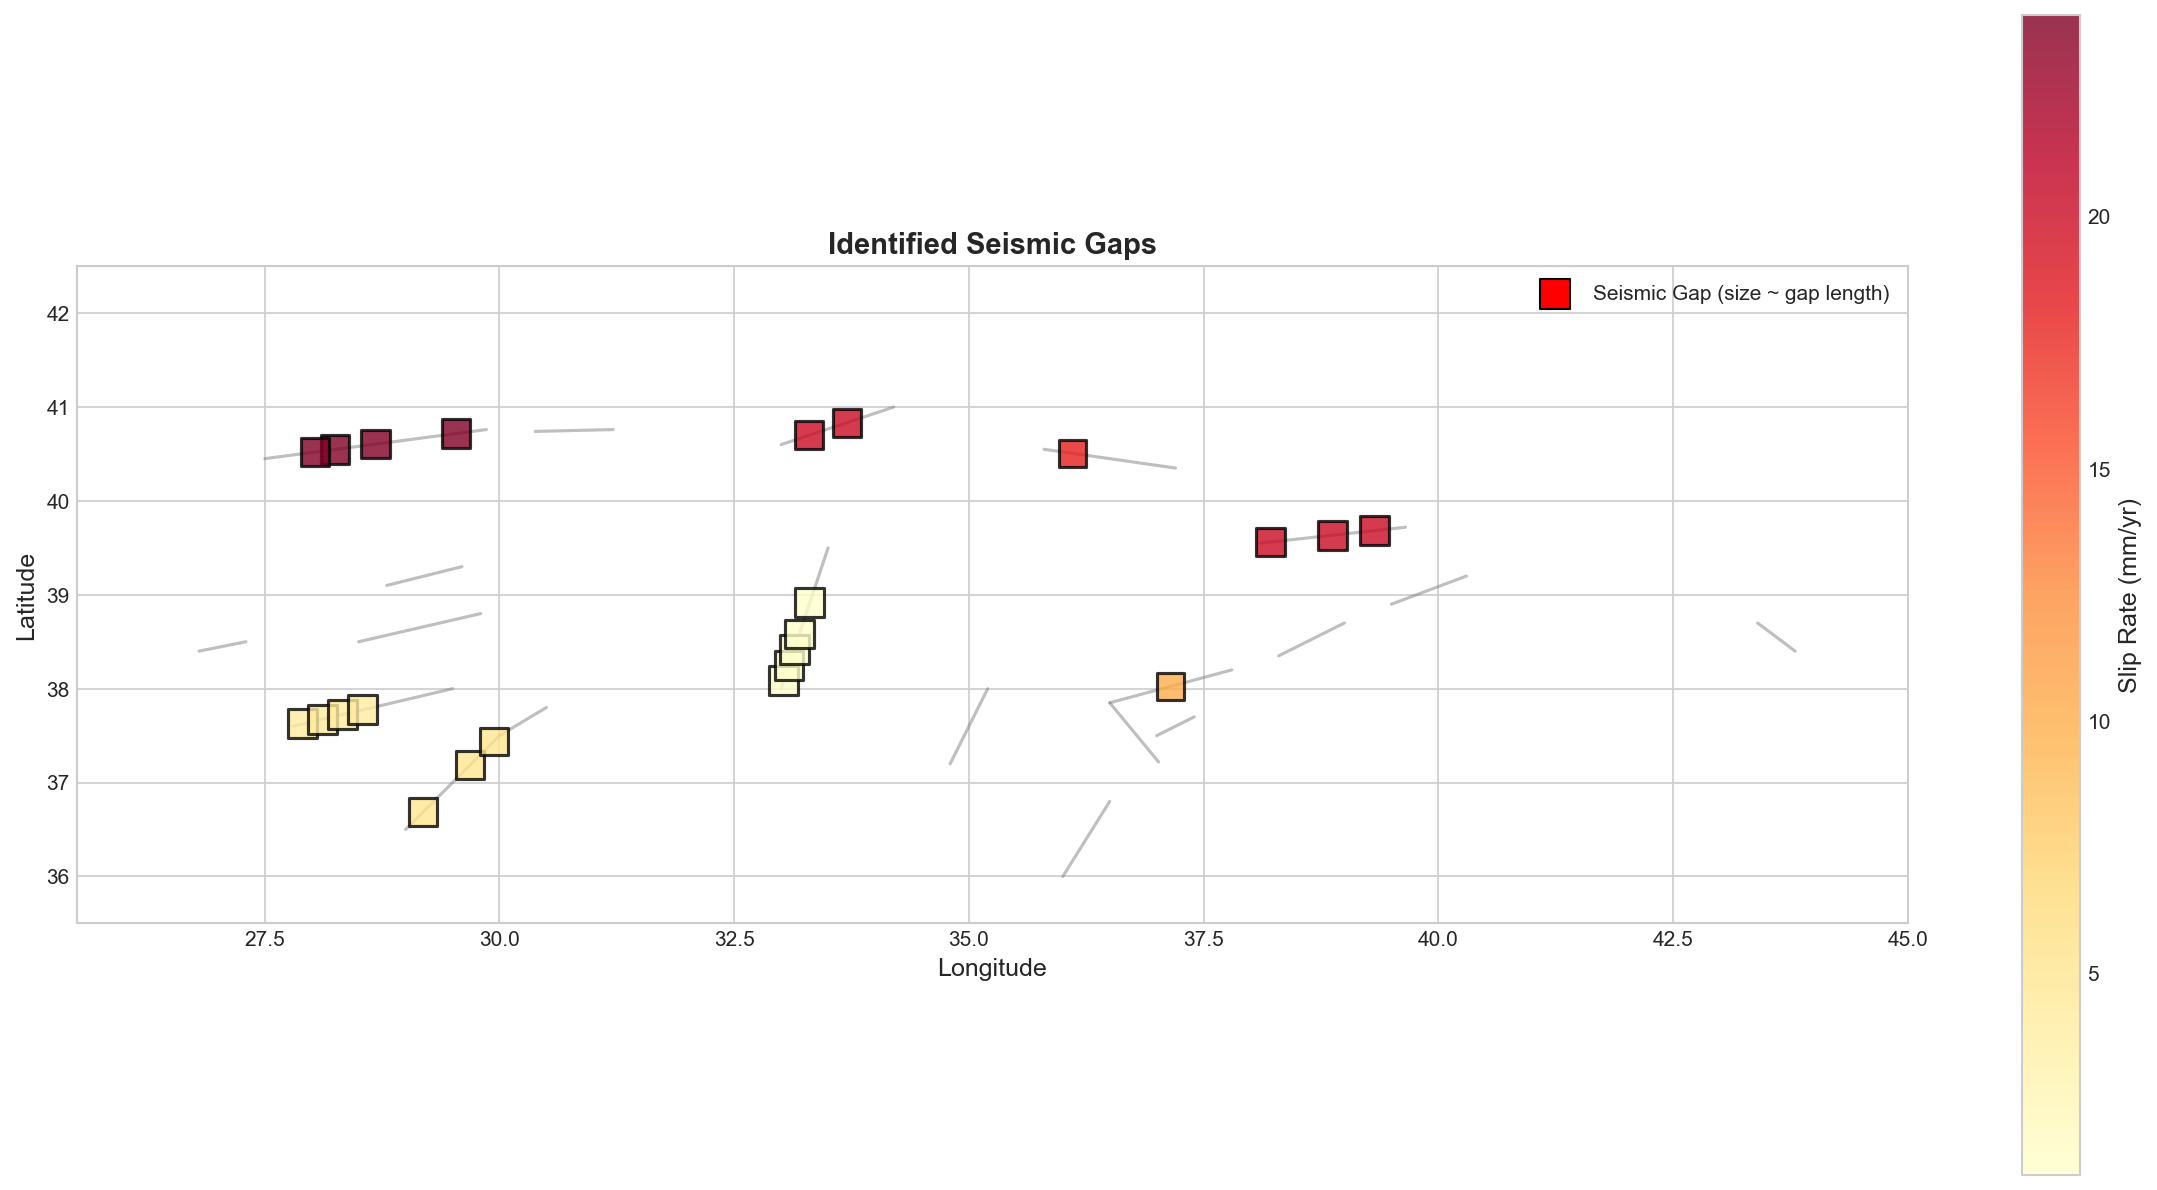

In [10]:
# Map of all identified gaps
fig, ax = plt.subplots(figsize=(16, 10))
ax = create_turkey_basemap(ax, 'Identified Seismic Gaps')

# Plot fault lines
for idx, fault in fault_df.iterrows():
    ax.plot([fault['lon_start'], fault['lon_end']], [fault['lat_start'], fault['lat_end']],
            color='gray', linewidth=1.5, alpha=0.5, zorder=2)

# Plot gaps
if len(gaps_df) > 0:
    scatter = ax.scatter(gaps_df['gap_lon'], gaps_df['gap_lat'],
                         s=gaps_df['gap_length_km'] * 10,
                         c=gaps_df['slip_rate_mm_yr'],
                         cmap='YlOrRd', alpha=0.8,
                         edgecolors='black', linewidth=1.5,
                         marker='s', zorder=10)
    plt.colorbar(scatter, ax=ax, label='Slip Rate (mm/yr)', shrink=0.8)

# Add legend
ax.scatter([], [], s=200, c='red', marker='s', edgecolors='black', 
           label='Seismic Gap (size ~ gap length)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'all_seismic_gaps_map.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Statistical Analysis of Gaps

In [11]:
# Statistical significance test
# Test if gap earthquake counts are significantly below expected (Poisson test)

print("Statistical Analysis of Seismic Gaps")
print("=" * 60)

for fault_name, data in all_gap_results.items():
    segments = data['segments']
    gaps = segments[segments['is_gap']]
    
    if len(gaps) > 0:
        mean_count = segments['earthquake_count'].mean()
        
        print(f"\n{fault_name}:")
        print(f"  Total segments: {len(segments)}")
        print(f"  Mean earthquakes/segment: {mean_count:.1f}")
        print(f"  Identified gaps: {len(gaps)}")
        
        for _, gap in gaps.iterrows():
            # Poisson probability of observing this few events
            if mean_count > 0:
                p_value = stats.poisson.cdf(gap['earthquake_count'], mean_count)
                print(f"    Segment {gap['segment_id']}: {gap['earthquake_count']} events (p={p_value:.4f})")

Statistical Analysis of Seismic Gaps

Kuzey Anadolu Fayı - Marmara Segmenti:
  Total segments: 11
  Mean earthquakes/segment: 7.7
  Identified gaps: 4
    Segment 1: 0 events (p=0.0004)
    Segment 5: 2 events (p=0.0170)
    Segment 7: 2 events (p=0.0170)
    Segment 8: 2 events (p=0.0170)

Kuzey Anadolu Fayı - Erzincan Segmenti:
  Total segments: 7
  Mean earthquakes/segment: 7.6
  Identified gaps: 3
    Segment 1: 2 events (p=0.0192)
    Segment 3: 1 events (p=0.0044)
    Segment 6: 2 events (p=0.0192)

Kuzey Anadolu Fayı - Niksar Segmenti:
  Total segments: 7
  Mean earthquakes/segment: 1.9
  Identified gaps: 1
    Segment 5: 0 events (p=0.1561)

Kuzey Anadolu Fayı - Tosya Segmenti:
  Total segments: 6
  Mean earthquakes/segment: 5.3
  Identified gaps: 2
    Segment 2: 1 events (p=0.0306)
    Segment 4: 0 events (p=0.0048)

Doğu Anadolu Fayı - Erkenek Segmenti:
  Total segments: 7
  Mean earthquakes/segment: 43.4
  Identified gaps: 1
    Segment 3: 10 events (p=0.0000)

Büyük Mender

In [12]:
# Risk ranking of gaps
if len(gaps_df) > 0:
    # Calculate risk score: higher slip rate + lower activity = higher risk
    gaps_df['risk_score'] = gaps_df['slip_rate_mm_yr'] * (1 - gaps_df['activity_ratio'])
    gaps_df = gaps_df.sort_values('risk_score', ascending=False)
    
    print("\n" + "=" * 60)
    print("TOP 10 HIGHEST RISK SEISMIC GAPS")
    print("=" * 60)
    
    display_cols = ['fault_name', 'gap_start_km', 'gap_end_km', 'earthquake_count', 
                    'slip_rate_mm_yr', 'max_expected_mag', 'risk_score']
    print(gaps_df[display_cols].head(10).to_string(index=False))


TOP 10 HIGHEST RISK SEISMIC GAPS
                            fault_name  gap_start_km  gap_end_km  earthquake_count  slip_rate_mm_yr  max_expected_mag  risk_score
 Kuzey Anadolu Fayı - Marmara Segmenti     18.380584   36.761167                 0               24               7.4   24.000000
   Kuzey Anadolu Fayı - Tosya Segmenti     73.577704   91.972130                 0               20               7.4   20.000000
  Kuzey Anadolu Fayı - Niksar Segmenti     86.093400  103.312080                 0               18               7.3   18.000000
 Kuzey Anadolu Fayı - Marmara Segmenti    128.664085  147.044668                 2               24               7.4   17.788235
 Kuzey Anadolu Fayı - Marmara Segmenti    147.044668  165.425252                 2               24               7.4   17.788235
 Kuzey Anadolu Fayı - Marmara Segmenti     91.902918  110.283501                 2               24               7.4   17.788235
Kuzey Anadolu Fayı - Erzincan Segmenti     57.458564   7

## 7. Export Results

In [13]:
# Save gap data
if len(gaps_df) > 0:
    gaps_df.to_csv(os.path.join(TABLES_PATH, 'seismic_gaps.csv'), index=False)
    print(f"Gap data saved to: {os.path.join(TABLES_PATH, 'seismic_gaps.csv')}")

# Save segment analysis for each fault
all_segments = []
for fault_name, data in all_gap_results.items():
    segments = data['segments'].copy()
    segments['fault_name'] = fault_name
    all_segments.append(segments)

if all_segments:
    all_segments_df = pd.concat(all_segments, ignore_index=True)
    all_segments_df.to_csv(os.path.join(TABLES_PATH, 'fault_segment_analysis.csv'), index=False)
    print(f"Segment analysis saved to: {os.path.join(TABLES_PATH, 'fault_segment_analysis.csv')}")

Gap data saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/seismic_gaps.csv
Segment analysis saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/fault_segment_analysis.csv


In [14]:
print("\n" + "=" * 60)
print("SEISMIC GAP ANALYSIS COMPLETE")
print("=" * 60)
print(f"\nKey Findings:")
print(f"  - Analyzed {len(all_gap_results)} major fault segments")
print(f"  - Identified {len(gaps_df)} potential seismic gaps")
if len(gaps_df) > 0:
    print(f"  - Highest risk gap: {gaps_df.iloc[0]['fault_name']}")
print(f"\nFigures saved to: {OUTPUT_DIR}")


SEISMIC GAP ANALYSIS COMPLETE

Key Findings:
  - Analyzed 8 major fault segments
  - Identified 23 potential seismic gaps
  - Highest risk gap: Kuzey Anadolu Fayı - Marmara Segmenti

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/05_seismic_gap
